## STEP 1: INSTALLATION & IMPORTS

In [ ]:
# --- 1. Installation ---
# Cài đặt tất cả các thư viện cần thiết.
# -qU: quiet (im lặng), upgrade (nâng cấp)
print("Bắt đầu cài đặt các thư viện...")
!pip install -qU langgraph langchain langchain-core langchain-community groq python-dotenv rich

Bắt đầu cài đặt các thư viện...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [ ]:
!pip install -qU tavily-python google-api-python-client google-auth-oauthlib
print("Đã cài đặt các thư viện công cụ cần thiết.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
Đã cài đặt các thư viện công cụ cần thiết.


In [ ]:
!pip install google-auth-httplib2 langchain-groq

In [ ]:
# --- 2. Core Imports ---
# Import các thư viện và lớp (class) cốt lõi sẽ được sử dụng trong toàn bộ dự án.
import os
import json
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from google.colab import userdata

# LangChain & LangGraph core components
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

# Groq client for LLM interaction
from groq import AsyncGroq

# Rich library for beautiful printing
from rich.console import Console
from rich.markdown import Markdown

SHOW_DETAILED_LOGS = True
SHOW_DETAILED_LOGS = False
print("\nCài đặt và Import hoàn tất. Môi trường đã sẵn sàng!")



Cài đặt và Import hoàn tất. Môi trường đã sẵn sàng!


## STEP 2: STATE DEFINITION & LLM WRAPPER

In [ ]:
# ==============================================================================
# STEP 2: STATE DEFINITION & LANGCHAIN LLM
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator
import json
import os
import tavily
from datetime import datetime, timezone, timedelta

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from rich.console import Console
from rich.markdown import Markdown
from google.colab import userdata
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END

# --- 1. State Definition (Hoàn chỉnh) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else: merged[key] = value
    return merged

class AcademicState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    profile: Dict
    cross_agent_request: Optional[Dict[str, Any]]
    required_agents: List[str]
    completed_agents: Annotated[List[str], operator.add]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts]
    critique: str
    revision_needed: bool
    revision_count: int
    final_report: str
    next_steps: str

print("Đã định nghĩa 'AcademicState' phiên bản cuối cùng thành công.")

# --- 2. Khởi tạo LLM ---
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
    llm = ChatGroq(
        temperature=0.2, # Giảm độ "sáng tạo" để agent tuân thủ hướng dẫn hơn
        model="llama3-70b-8192",
        api_key=GROQ_API_KEY,
        max_tokens=4096
    )
    print(f"Khởi tạo ChatGroq thành công với model: {llm.model_name}")
except Exception as e:
    print(f"LỖI: Không thể khởi tạo LLM. {e}")
    llm = None
console = Console()
if llm: print("\nKhởi tạo 'llm' và 'console' thành công.")



Đã định nghĩa 'AcademicState' phiên bản cuối cùng thành công.
Khởi tạo ChatGroq thành công với model: llama3-70b-8192

Khởi tạo 'llm' và 'console' thành công.


In [ ]:
# ==============================================================================
# STEP 3: THE TOOLBOX
# ==============================================================================
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

# --- 1. Khởi tạo các service và dữ liệu ---
SERVICE_ACCOUNT_FILE = 'credentials.json'
YOUR_CALENDAR_ID = "td.tan2711@gmail.com"

def authenticate_google_calendar_service_account():
    try:
        if not os.path.exists(SERVICE_ACCOUNT_FILE): return None
        SCOPES = ['https://www.googleapis.com/auth/calendar.readonly']
        creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        service = build('calendar', 'v3', credentials=creds)
        print("✅ Xác thực Google Calendar thành công.")
        return service
    except Exception as e:
        print(f"Lỗi khi xác thực Google Calendar: {e}")
        return None
google_calendar_service = authenticate_google_calendar_service_account()

# <-- ĐÃ XÓA PHẦN ĐỌC TASKS.JSON

try:
    with open('profile.json', 'r', encoding='utf-8') as f: profile_data = json.load(f)
    print("✅ Đã tải dữ liệu profile.json thành công.")
except Exception as e:
    profile_data = {}
    print(f"Lỗi khi tải profile.json: {e}")

# --- 2. Định nghĩa các công cụ ---
@tool
def google_calendar_reader(days_ahead: int = 7) -> str:
    """Đọc lịch và các sự kiện sắp tới của người dùng."""
    if not google_calendar_service: return "Lỗi: Dịch vụ Google Calendar không có sẵn."
    now_utc = datetime.now(timezone.utc).isoformat()
    future_limit = (datetime.now(timezone.utc) + timedelta(days=days_ahead)).isoformat()
    try:
        print(f"--- [Calendar Tool] Đang đọc lịch: {YOUR_CALENDAR_ID}")
        events_result = google_calendar_service.events().list(
            calendarId=YOUR_CALENDAR_ID, timeMin=now_utc, timeMax=future_limit,
            singleEvents=True, orderBy='startTime'
        ).execute()
        events = events_result.get('items', [])
        if not events: return f"Không có sự kiện nào sắp tới trong {days_ahead} ngày tới."
        print(f"--- [Calendar Tool] Tìm thấy {len(events)} sự kiện.")
        return json.dumps([{'summary': e.get('summary'), 'start': e.get('start', {}).get('dateTime'), 'end': e.get('end', {}).get('dateTime')} for e in events])
    except Exception as e: return f"Lỗi khi gọi Google Calendar API: {e}"


@tool
def tavily_web_search(query: str) -> str:
    """Tìm kiếm thông tin học thuật trên Internet."""
    try:
        client = tavily.TavilyClient(api_key=TAVILY_API_KEY)
        response = client.search(query=query, search_depth="advanced", max_results=3)
        return "\n\n".join([f'Source: {res["url"]}\nContent: {res["content"]}' for res in response["results"]])
    except Exception as e: return f"Lỗi khi tìm kiếm với Tavily: {e}"

# --- 3. Tạo danh sách và bind các công cụ ---
# <-- ĐÃ XÓA `active_tasks_reader` KHỎI DANH SÁCH
tools = [google_calendar_reader, tavily_web_search]
llm_with_tools = llm.bind_tools(tools)
print("\n✅ Hộp dụng cụ (Toolbox) đã sẵn sàng và được bind vào LLM.")

✅ Xác thực Google Calendar thành công.
✅ Đã tải dữ liệu profile.json thành công.

✅ Hộp dụng cụ (Toolbox) đã sẵn sàng và được bind vào LLM.


In [ ]:
# ==============================================================================
# STEP 4: THE FULL INTERACTIVE TEAM OF AGENTS
# ==============================================================================
import re
import time
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal, Dict, Any

# --- 1. Định nghĩa các cấu trúc dữ liệu cho tương tác ---
class FinalAnswer(BaseModel):
    """Sử dụng để cung cấp câu trả lời cuối cùng."""
    answer: str = Field(description="Nội dung câu trả lời cuối cùng, chi tiết bằng Markdown.")

# --- 2. Xây dựng các Agent ---

async def coordinator_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---")

    # <-- NÂNG CẤP: Thêm logic phân tích từ khóa
    prompt = f"""Bạn là một Coordinator Agent bậc thầy. Nhiệm vụ của bạn là phân tích yêu cầu của người dùng để quyết định chính xác agent nào cần được kích hoạt.

    **CÁC AGENT CÓ SẴN VÀ KHI NÀO NÊN DÙNG:**
    - `PLANNER`: CHỈ kích hoạt khi yêu cầu có các từ khóa rõ ràng liên quan đến **lập kế hoạch, lịch trình, sắp xếp thời gian, tuần tới, deadline**.
    - `NOTEWRITER`: Kích hoạt khi yêu cầu liên quan đến **tìm hiểu, tóm tắt, ghi chú, giải thích một chủ đề**.
    - `ADVISOR`: Kích hoạt khi yêu cầu có các từ khóa liên quan đến **lời khuyên, phương pháp, cách học, mẹo**.

    **YÊU CẦU CỦA NGƯỜI DÙNG:**
    "{state['messages'][0].content}"

    Dựa vào các quy tắc trên, hãy phân tích yêu cầu và trả về một danh sách Python chứa tên các agent cần thiết.

    Ví dụ:
    - Yêu cầu: "lập kế hoạch học về RAG cho tuần tới" -> ["PLANNER", "NOTEWRITER"]
    - Yêu cầu: "giải thích cho tôi về RAG" -> ["NOTEWRITER"]
    - Yêu cầu: "cho tôi vài mẹo để học RAG hiệu quả" -> ["ADVISOR", "NOTEWRITER"]
    """

    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    try:
        # Cố gắng tìm danh sách Python trong phản hồi
        # Regex này tìm một chuỗi trông giống như một danh sách Python
        match = re.search(r'\[\s*([^\]]*?)\s*\]', response_message.content)
        if match:
            # Lấy nội dung bên trong dấu ngoặc vuông và chuyển thành danh sách
            agent_list_str = f"[{match.group(1)}]"
            required_agents = eval(agent_list_str)
        else:
            raise ValueError("Không tìm thấy danh sách trong phản hồi")

        if not isinstance(required_agents, list): raise ValueError
    except:
        # Nếu có lỗi, kích hoạt tất cả như một giải pháp an toàn
        required_agents = ["PLANNER", "NOTEWRITER", "ADVISOR"]

    print(f"--- [Coordinator] Quyết định: Cần các agent {required_agents}")
    return {"required_agents": required_agents}

async def tool_user_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Tool User] Thu thập tất cả thông tin ban đầu... ---")
    request = state['messages'][0].content
    search_query = f"Hướng dẫn học và các tài liệu tốt nhất về '{request}'"
    print(f"--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'tavily_web_search']")
    calendar_output = google_calendar_reader.invoke({"days_ahead": 7})
    time.sleep(1)
    web_output = tavily_web_search.invoke({"query": search_query})
    collected_data = f"""Thông tin ban đầu đã được thu thập:
    1. Lịch trình trong 7 ngày tới: {calendar_output}
    2. Kết quả tìm kiếm trên web: {web_output}"""
    context_message = SystemMessage(content=collected_data)
    print("--- [Tool User] Đã thu thập và định dạng xong thông tin.")
    return {"messages": [context_message]}

def create_specialist_agent(agent_name: str, agent_description: str, output_key: str):
    async def specialist_agent(state: AcademicState) -> Dict[str, Any]:
        print(f"\n--- [{agent_name}] Bắt đầu làm việc... ---")
        llm_with_tool = llm.bind_tools([FinalAnswer])

        if agent_name == "PLANNER":
            prompt_content = f"""Bạn là {agent_name}. {agent_description}.
            Dựa vào thông tin ban đầu (lịch trình, kết quả tìm kiếm), hãy tạo ra một kế hoạch học tập chi tiết, khả thi.
            **Thông tin có sẵn:**
            ```json
            {json.dumps({
                "profile": state['profile'],
                "messages": [msg.model_dump() for msg in state['messages']],
            }, indent=2, ensure_ascii=False)}
            ```
            """
        else:
            prompt_content = f"""Bạn là {agent_name}. {agent_description}.
            Dựa vào KẾ HOẠCH HỌC TẬP đã được tạo ra dưới đây và thông tin ban đầu, hãy tạo ra sản phẩm chuyên môn của bạn.
            **Đừng lặp lại kế hoạch**, hãy tạo ra một nội dung mới dựa trên nó.
            **Thông tin để tham khảo:**
            ```json
            {json.dumps({
                "profile": state['profile'],
                "messages": [msg.model_dump() for msg in state['messages']],
                "agent_outputs": state['agent_outputs'],
            }, indent=2, ensure_ascii=False)}
            ```
            """

        prompt = f"{prompt_content}\nHãy tạo ra câu trả lời cuối cùng của bạn và gọi công cụ `FinalAnswer`."

        try:
            ai_response = await llm_with_tool.ainvoke([HumanMessage(content=prompt)])
            if not ai_response.tool_calls:
                print(f"--- [{agent_name}] Cảnh báo: Không gọi được tool, trả về nội dung thô.")
                return {"agent_outputs": {output_key: ai_response.content}}
            tool_call = ai_response.tool_calls[0]
            if tool_call['name'] == 'FinalAnswer':
                print(f"--- [{agent_name}] Đã tạo sản phẩm thành công.")
                return {"agent_outputs": {output_key: tool_call['args']['answer']}}
            else:
                raise ValueError(f"LLM đã gọi một công cụ không xác định: {tool_call['name']}")
        except Exception as e:
            # --- LOGIC NÂNG CẤP ---
            # Chỉ in lỗi chi tiết nếu đang ở chế độ debug
            if SHOW_DETAILED_LOGS:
                print(f"--- [{agent_name}] Gặp lỗi API: {e}")

            error_str = str(e)
            match = re.search(r'"answer":\s*"(.*?)"', error_str, re.DOTALL)
            if match:
                extracted_answer = match.group(1).encode().decode('unicode_escape')
                print(f"--- [{agent_name}] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.")
                return {"agent_outputs": {output_key: extracted_answer}}
            else:
                print(f"--- [{agent_name}] Không thể cứu sản phẩm. Trả về thông báo lỗi.")
                return {"agent_outputs": {output_key: f"Agent {agent_name} đã gặp lỗi không thể phục hồi."}}
    return specialist_agent

planner_agent = create_specialist_agent("PLANNER", "Tạo kế hoạch học tập chi tiết, khả thi.", "plan")
notewriter_agent = create_specialist_agent("NOTEWRITER", "Tạo ghi chú học thuật súc tích.", "notes")
advisor_agent = create_specialist_agent("ADVISOR", "Đưa ra lời khuyên chiến lược.", "advice")

async def synthesizer_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---")
    prompt = f"Tổng hợp các sản phẩm từ các chuyên gia (Kế hoạch, Ghi chú, Lời khuyên) sau đây thành MỘT báo cáo tổng hợp duy nhất, mạch lạc và chuyên nghiệp cho người dùng:\n\n{json.dumps(state['agent_outputs'], indent=2, ensure_ascii=False)}.\n\nYêu cầu ban đầu của người dùng là: '{state['messages'][0].content}'"
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    return {"final_report": response_message.content}

async def reflection_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---")
    prompt = f"Dựa vào báo cáo cuối cùng này, hãy đề xuất 3-4 hành động hoặc câu hỏi tiếp theo mà người dùng có thể muốn thực hiện:\n\n{state['final_report']}"
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    return {"next_steps": response_message.content}

print("✅ Tất cả các agent cho ATLAS 2.0 (Phiên bản chuyên môn hóa) đã được định nghĩa.")

✅ Tất cả các agent cho ATLAS 2.0 (Phiên bản chuyên môn hóa) đã được định nghĩa.


In [ ]:
# ==============================================================================
# STEP 5 & 6: ASSEMBLY & EXECUTION (KIẾN TRÚC ĐỘNG - ĐÃ SỬA LỖI)
# ==============================================================================

# --- 1. Master Router ---
def master_router(state: AcademicState) -> Literal["planner", "notewriter", "advisor", "synthesizer"]:
    """Router này kiểm tra trạng thái và quyết định agent nào sẽ chạy tiếp theo."""
    required = state.get("required_agents", [])
    completed = state.get("completed_agents", [])
    next_agent = next((agent for agent in required if agent not in completed), None)

    if next_agent:
        print(f"\n--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là '{next_agent}' ---")
        return next_agent.lower()
    else:
        print("\n--- [Master Router] Tất cả các chuyên gia đã hoàn thành. Chuyển đến Synthesizer. ---")
        return "synthesizer"

# --- 2. Node Wrapper và các Node chuyên biệt ---
# Hàm wrapper vẫn giữ vai trò quan trọng: chạy agent và đánh dấu nó đã hoàn thành.
async def specialist_node_wrapper(agent_func, agent_name: str, state: AcademicState) -> Dict[str, Any]:
    result = await agent_func(state)
    current_completed = state.get("completed_agents", [])
    if agent_name not in current_completed:
        result["completed_agents"] = current_completed + [agent_name]
    return result

# <-- SỬA ĐỔI QUAN TRỌNG: Định nghĩa các node một cách tường minh, không dùng lambda
async def planner_node(state: AcademicState) -> Dict[str, Any]:
    """Chạy Planner agent và cập nhật trạng thái."""
    return await specialist_node_wrapper(planner_agent, "PLANNER", state)

async def notewriter_node(state: AcademicState) -> Dict[str, Any]:
    """Chạy Notewriter agent và cập nhật trạng thái."""
    return await specialist_node_wrapper(notewriter_agent, "NOTEWRITER", state)

async def advisor_node(state: AcademicState) -> Dict[str, Any]:
    """Chạy Advisor agent và cập nhật trạng thái."""
    return await specialist_node_wrapper(advisor_agent, "ADVISOR", state)

# --- 3. Lắp ráp Graph với Cạnh Điều Kiện ---
workflow = StateGraph(AcademicState)

# Thêm tất cả các node như bình thường
workflow.add_node("coordinator", coordinator_agent)
workflow.add_node("tool_user", tool_user_agent)
# Sử dụng các hàm async def đã được định nghĩa đúng cách
workflow.add_node("planner", planner_node)
workflow.add_node("notewriter", notewriter_node)
workflow.add_node("advisor", advisor_node)
workflow.add_node("synthesizer", synthesizer_agent)
workflow.add_node("reflection", reflection_agent)

workflow.set_entry_point("coordinator")

# Định nghĩa các cạnh cố định
workflow.add_edge("coordinator", "tool_user")
workflow.add_edge("synthesizer", "reflection")
workflow.add_edge("reflection", END)

# Sử dụng Cạnh Điều Kiện để tạo luồng đi động
# Sau khi Tool User hoặc bất kỳ agent chuyên môn nào chạy xong, nó sẽ đi đến Master Router
# để router quyết định bước tiếp theo.
possible_routes = {
    "planner": "planner",
    "notewriter": "notewriter",
    "advisor": "advisor",
    "synthesizer": "synthesizer"
}

###
workflow.add_conditional_edges("tool_user", master_router, possible_routes)
workflow.add_conditional_edges("planner", master_router, possible_routes)
workflow.add_conditional_edges("notewriter", master_router, possible_routes)
workflow.add_conditional_edges("advisor", master_router, possible_routes)


# Biên dịch Graph
app = workflow.compile()
print("\n✅✅✅ ATLAS 3.0 (Kiến trúc động với Router) đã được biên dịch! ✅✅✅")


✅✅✅ ATLAS 3.0 (Kiến trúc động với Router) đã được biên dịch! ✅✅✅


In [ ]:
# ==============================================================================
# STEP 7: EXECUTION
# ==============================================================================

async def run_atlas_2_0(profile_data: dict):
    request = "Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập."

    student_profile = next((p for p in profile_data.get("profiles", []) if p.get("id") == "student_123"), {})

    initial_state = {
        "messages": [HumanMessage(content=request)],
        "profile": student_profile,
        "agent_outputs": {},
        "completed_agents": [],
    }

    console.print(f"\n🚀 [bold blue]Bắt đầu chạy ATLAS 2.0 với yêu cầu:[/bold blue]\n{request}")

    # Chạy và xem log của từng bước
    async for step in app.astream(initial_state, config={"recursion_limit": 15}):
        node_name = list(step.keys())[0]
        console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
        console.print(step[node_name])

# Chạy hàm chính
await run_atlas_2_0(profile_data)

🚀 Bắt đầu chạy ATLAS 2.0 với yêu cầu:
Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học 
tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập.


--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---
--- [Coordinator] Quyết định: Cần các agent ['PLANNER', 'NOTEWRITER', 'ADVISOR']


✅ Hoàn thành bước: coordinator

{'required_agents': ['PLANNER', 'NOTEWRITER', 'ADVISOR']}


--- [Tool User] Thu thập tất cả thông tin ban đầu... ---
--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'tavily_web_search']
--- [Calendar Tool] Đang đọc lịch: td.tan2711@gmail.com
--- [Calendar Tool] Tìm thấy 4 sự kiện.
--- [Tool User] Đã thu thập và định dạng xong thông tin.

--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là 'PLANNER' ---


✅ Hoàn thành bước: tool_user

{
    'messages': [
        SystemMessage(
            content='Thông tin ban đầu đã được thu thập:\n    1. Lịch trình trong 7 ngày tới: [{"summary": "Work 
Online", "start": "2025-08-08T19:45:00+07:00", "end": "2025-08-08T21:15:00+07:00"}, {"summary": "Take a nap", 
"start": "2025-08-11T08:45:00+07:00", "end": "2025-08-11T13:00:00+07:00"}, {"summary": "have a trip", "start": 
"2025-08-12T01:30:00+07:00", "end": "2025-08-12T05:30:00+07:00"}, {"summary": "go swimming", "start": 
"2025-08-14T07:15:00+07:00", "end": "2025-08-14T11:45:00+07:00"}]\n    2. Kết quả tìm kiếm trên web: Source: 
https://machinelearningcoban.com/2017/01/08/knn/\nContent: K-nearest neighbor là một trong những thuật toán 
supervised-learning đơn giản nhất (mà hiệu quả trong một vài trường hợp) trong Machine Learning\n\nSource: 
https://aicandy.vn/kham-pha-k-nearest-neighbors-cho-phan-loai-va-hoi-quy/\nContent: *   KNN có thể sử dụng thông 
tin từ các ngày giao dịch trước để dự đoán giá cổ phiếu vào ngày hiện tại hoặc tương lai gần bằng cách tìm kiếm các
ngày có các đặc điểm tương tự (như giá mở cửa, giá đóng cửa, khối lượng giao dịch) và dự đoán dựa trên các ngày đó.
*   Trong ứng dụng này, KNN cần một tập dữ liệu lớn và đa dạng để đảm bảo rằng các dự đoán có độ chính xác cao, đặc
biệt khi phân tích trên các nhóm dân số khác nhau. Để triển khai KNN hiệu quả, cần phải lựa chọn giá trị `k` một 
cách cẩn thận và đảm bảo rằng dữ liệu đã được tiền xử lý tốt để loại bỏ các đặc trưng không liên quan hoặc 
nhiễu.\n\nSource: https://viblo.asia/p/knn-k-nearest-neighbors-1-djeZ14ejKWz\nContent: Có thể thấy cách đơn giản 
nhất là so sánh tất cả các đặc điểm của dữ liệu A với tất cả tập dữ liệu học đã được gắn nhãn và xem nó giống cái 
nào nhất, nếu dữ liệu (đặc điểm) của A giống với dữ liệu của điểm mang nhãn (+) thì điểm A mang nhãn (+), nếu dữ 
liệu A giống với dữ liệu nhãn (-) hơn thì nó mang nhãn (-), trông có vẻ rất đơn giản nhưng đó là những gì mà KNN 
làm. Trong trường hợp của KNN, thực tế nó không so sánh dữ liệu mới (không được phân lớp) với tất cả các dữ liệu 
khác, thực tế nó thực hiện một phép tính toán học để đo khoảng cách giữa dữ liệu mới với tất cả các điểm trong tập 
dữ liệu học D để thực hiện phân lớp.',
            additional_kwargs={},
            response_metadata={}
        )
    ]
}


--- [PLANNER] Bắt đầu làm việc... ---
--- [PLANNER] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.

--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là 'NOTEWRITER' ---


✅ Hoàn thành bước: planner

{
    'agent_outputs': {
        'plan': 'Here is a detailed learning plan for you to learn about K-Nearest Neighbors (KNN) 
algorithm:\n\n**Day 1-2:**\n- Morning (9 AM - 12 PM): Study the basics of KNN algorithm, its applications, and 
importance in Machine Learning.\n- Review the collected information from the web, focusing on the simplicity and 
effectiveness of KNN.\n- Take notes and create a mind map to visualize the concept.\n\n**Day 3-4:**\n- Morning (9 
AM - 12 PM): Dive deeper into the implementation of KNN, including the selection of the value of k and data 
preprocessing.\n- Watch videos and diagrams to understand the calculation of distances and the classification 
process.\n- Take a 15-minute break every 45 minutes to refresh your mind.\n\n**Day 5-6:**\n- Morning (9 AM - 12 
PM): Practice implementing KNN using a dataset and evaluating its performance.\n- Review the importance of having a
large and diverse dataset for accurate predictions.\n- Take breaks to relax and recharge.\n\n**Day 7:**\n- Morning 
(9 AM - 12 PM): Review the entire concept of KNN, its applications, and limitations.\n- Create a summary of the key
points and takeaways from the learning process.\n- Feel confident and prepared to apply KNN in real-world 
scenarios.\n\nSome additional tips for you:\n- Make sure to take breaks and not overwork yourself.\n- Use diagrams 
and mind maps to visualize the concept and make it easier to understand.\n- Practice implementing KNN to reinforce 
your learning.'
    },
    'completed_agents': ['PLANNER']
}


--- [NOTEWRITER] Bắt đầu làm việc... ---
--- [NOTEWRITER] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.

--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là 'ADVISOR' ---


✅ Hoàn thành bước: notewriter

{
    'agent_outputs': {
        'notes': 'Here is a concise academic note based on the provided learning plan and 
information:\n\n**K-Nearest Neighbors (KNN) Algorithm**\n\n*   KNN is a simple yet effective supervised learning 
algorithm in Machine Learning.\n*   It can be used to predict stock prices by finding similar patterns in 
historical data.\n*   To implement KNN effectively, a large and diverse dataset is required, and the value of k 
must be carefully selected.\n*   Data preprocessing is crucial to remove irrelevant features and noise.\n*   The 
algorithm calculates distances between the new data and the labeled data to make predictions.\n\n**Learning 
Tips**\n\n*   Use diagrams and mind maps to visualize the concept and make it easier to understand.\n*   Practice 
implementing KNN to reinforce your learning.\n*   Take breaks and not overwork yourself to maintain focus and 
productivity.'
    },
    'completed_agents': ['PLANNER', 'NOTEWRITER']
}


--- [ADVISOR] Bắt đầu làm việc... ---
--- [ADVISOR] Đã tạo sản phẩm thành công.

--- [Master Router] Tất cả các chuyên gia đã hoàn thành. Chuyển đến Synthesizer. ---


✅ Hoàn thành bước: advisor

{
    'agent_outputs': {
        'advice': 'Here is a concise academic note based on the provided learning plan and 
information:\n\n**K-Nearest Neighbors (KNN) Algorithm**\n\n*   KNN is a simple yet effective supervised learning 
algorithm in Machine Learning.\n*   It can be used to predict stock prices by finding similar patterns in 
historical data.\n*   To implement KNN effectively, a large and diverse dataset is required, and the value of k 
must be carefully selected.\n*   Data preprocessing is crucial to remove irrelevant features and noise.\n*   The 
algorithm calculates distances between the new data and the labeled data to make predictions.\n\n**Learning 
Tips**\n\n*   Use diagrams and mind maps to visualize the concept and make it easier to understand.\n*   Practice 
implementing KNN to reinforce your learning.\n*   Take breaks and not overwork yourself to maintain focus and 
productivity.'
    },
    'completed_agents': ['PLANNER', 'PLANNER', 'NOTEWRITER', 'ADVISOR']
}


--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---


✅ Hoàn thành bước: synthesizer

{
    'final_report': 'Here is a comprehensive report that combines the plan, notes, and advice into a single, 
cohesive, and professional document:\n\n**Learning Report: K-Nearest Neighbors (KNN) Algorithm**\n\n**Learning 
Plan**\n\nTo help you learn about the K-Nearest Neighbors (KNN) algorithm, we have created a detailed learning plan
for you to follow over the next week.\n\n**Day 1-2:**\n\n* Morning (9 AM - 12 PM): Study the basics of KNN 
algorithm, its applications, and importance in Machine Learning.\n* Review the collected information from the web, 
focusing on the simplicity and effectiveness of KNN.\n* Take notes and create a mind map to visualize the 
concept.\n\n**Day 3-4:**\n\n* Morning (9 AM - 12 PM): Dive deeper into the implementation of KNN, including the 
selection of the value of k and data preprocessing.\n* Watch videos and diagrams to understand the calculation of 
distances and the classification process.\n* Take a 15-minute break every 45 minutes to refresh your mind.\n\n**Day
5-6:**\n\n* Morning (9 AM - 12 PM): Practice implementing KNN using a dataset and evaluating its performance.\n* 
Review the importance of having a large and diverse dataset for accurate predictions.\n* Take breaks to relax and 
recharge.\n\n**Day 7:**\n\n* Morning (9 AM - 12 PM): Review the entire concept of KNN, its applications, and 
limitations.\n* Create a summary of the key points and takeaways from the learning process.\n* Feel confident and 
prepared to apply KNN in real-world scenarios.\n\n**Additional Tips:**\n\n* Make sure to take breaks and not 
overwork yourself.\n* Use diagrams and mind maps to visualize the concept and make it easier to understand.\n* 
Practice implementing KNN to reinforce your learning.\n\n**Key Notes**\n\nHere are the key points to remember about
the K-Nearest Neighbors (KNN) algorithm:\n\n* KNN is a simple yet effective supervised learning algorithm in 
Machine Learning.\n* It can be used to predict stock prices by finding similar patterns in historical data.\n* To 
implement KNN effectively, a large and diverse dataset is required, and the value of k must be carefully 
selected.\n* Data preprocessing is crucial to remove irrelevant features and noise.\n* The algorithm calculates 
distances between the new data and the labeled data to make predictions.\n\n**Learning Tips**\n\nHere are some 
additional tips to help you learn effectively:\n\n* Use diagrams and mind maps to visualize the concept and make it
easier to understand.\n* Practice implementing KNN to reinforce your learning.\n* Take breaks and not overwork 
yourself to maintain focus and productivity.\n\nBy following this learning plan and taking note of the key points 
and tips, you will be well on your way to mastering the K-Nearest Neighbors (KNN) algorithm. Good luck!'
}


--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---


✅ Hoàn thành bước: reflection

{
    'next_steps': 'Based on this comprehensive report, here are 3-4 potential next actions or questions that the 
user may want to take:\n\n1. **Implement KNN on a real-world dataset**: Now that the user has a solid understanding
of the KNN algorithm, they may want to apply it to a real-world dataset to practice and reinforce their learning. 
They could choose a dataset from a platform like Kaggle or UCI Machine Learning Repository and try to implement KNN
to solve a problem or make predictions.\n\n2. **Explore other supervised learning algorithms**: Having learned 
about KNN, the user may be interested in exploring other supervised learning algorithms, such as decision trees, 
random forests, or support vector machines. They could create a new learning plan to learn about these algorithms 
and compare their strengths and weaknesses with KNN.\n\n3. **Apply KNN to a specific domain or industry**: The user
may want to explore how KNN can be applied to a specific domain or industry, such as finance, healthcare, or 
marketing. They could research how KNN is being used in these areas and think about how they can apply their 
knowledge to solve real-world problems.\n\n4. **How can I improve the performance of KNN?**: The user may want to 
investigate ways to improve the performance of KNN, such as handling imbalanced datasets, dealing with noisy data, 
or using techniques like cross-validation and grid search to optimize hyperparameters. They could research these 
topics and experiment with different approaches to improve the accuracy of their KNN models.'
}

In [ ]:
from rich.panel import Panel

SHOW_STEP_BY_STEP_LOGS = False

async def run_atlas_2_0(profile_data: dict):
    request = "Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập."

    student_profile = next((p for p in profile_data.get("profiles", []) if p.get("id") == "student_123"), {})

    initial_state = {
        "messages": [HumanMessage(content=request)],
        "profile": student_profile,
        "agent_outputs": {},
        "completed_agents": [],
    }

    console.print(Panel(f"[bold]Yêu cầu:[/bold]\n{request}", title="🚀 [bold green]BẮT ĐẦU CHẠY HỆ THỐNG ATLAS 2.0[/bold green]", border_style="green"))

    final_state = None

    if SHOW_STEP_BY_STEP_LOGS:
        print("\n--- [Hệ thống] Chạy ở chế độ log chi tiết... ---")
        async for step in app.astream(initial_state, config={"recursion_limit": 15}):
            node_name = list(step.keys())[0]
            console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
            console.print(step[node_name])
        final_state = await app.ainvoke(initial_state, config={"recursion_limit": 15})
    else:
        # Nếu không bật log, chạy ngầm bằng ainvoke để có kết quả nhanh nhất
        print("\n--- [Hệ thống] Đang chạy, vui lòng chờ... ---")
        final_state = await app.ainvoke(initial_state, config={"recursion_limit": 15})

    console.print("\n\n" + "="*80, style="bold green")
    console.print(" HỆ THỐNG ATLAS 2.0 ĐÃ HOÀN THÀNH TÁC VỤ!", style="bold green")
    console.print("="*80, style="bold green")

    if final_state:
        # In Báo cáo tổng hợp trong một Panel
        report_panel = Panel(
            Markdown(final_state.get("final_report", "Không có báo cáo cuối cùng.")),
            title="📑 [bold blue]BÁO CÁO TỔNG HỢP[/bold blue]",
            border_style="blue",
            padding=(1, 2)
        )
        console.print(report_panel)

        next_steps_panel = Panel(
            Markdown(final_state.get("next_steps", "Không có gợi ý.")),
            title="💡 [bold yellow]GỢI Ý CÁC BƯỚC TIẾP THEO[/bold yellow]",
            border_style="yellow",
            padding=(1, 2)
        )
        console.print(next_steps_panel)

await run_atlas_2_0(profile_data)

╭────────────────────────────────────── 🚀 BẮT ĐẦU CHẠY HỆ THỐNG ATLAS 2.0 ───────────────────────────────────────╮
│ Yêu cầu:                                                                                                        │
│ Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch    │
│ học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- [Hệ thống] Đang chạy, vui lòng chờ... ---

--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---
--- [Coordinator] Quyết định: Cần các agent ['PLANNER', 'NOTEWRITER', 'ADVISOR']

--- [Tool User] Thu thập tất cả thông tin ban đầu... ---
--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'tavily_web_search']
--- [Calendar Tool] Đang đọc lịch: td.tan2711@gmail.com
--- [Calendar Tool] Tìm thấy 4 sự kiện.
--- [Tool User] Đã thu thập và định dạng xong thông tin.

--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là 'PLANNER' ---

--- [PLANNER] Bắt đầu làm việc... ---
--- [PLANNER] Gặp lỗi API nhỏ, đã tự động phục hồi sản phẩm.

--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là 'NOTEWRITER' ---

--- [NOTEWRITER] Bắt đầu làm việc... ---
--- [NOTEWRITER] Đã tạo sản phẩm thành công.

--- [Master Router] Quyết định: Chuyển đến agent tiếp theo là 'ADVISOR' ---

--- [ADVISOR] Bắt đầu làm việc... ---
--- [ADVISOR] Đã tạo sản phẩm thành công.

---

================================================================================

 HỆ THỐNG ATLAS 2.0 ĐÃ HOÀN THÀNH TÁC VỤ!

================================================================================

╭────────────────────────────────────────────── 📑 BÁO CÁO TỔNG HỢP ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Here is a comprehensive report that combines the plan, notes, and advice into a single, cohesive, and          │
│  professional document:                                                                                         │
│                                                                                                                 │
│  Learning Report: K-Nearest Neighbors (KNN) Algorithm                                                           │
│                                                                                                                 │
│  Introduction                                                                                                   │
│                                                                                                                 │
│  As per your request, we have created a detailed learning plan to help you learn about the K-Nearest Neighbors  │
│  (KNN) algorithm. This report provides a comprehensive overview of the plan, key notes, and valuable advice to  │
│  ensure you grasp the concept effectively.                                                                      │
│                                                                                                                 │
│  Learning Plan                                                                                                  │
│                                                                                                                 │
│  To learn about KNN algorithm, we recommend the following 7-day plan:                                           │
│                                                                                                                 │
│  Day 1-2                                                                                                        │
│                                                                                                                 │
│   • Morning (9 AM - 12 PM): Study the basics of KNN algorithm, including its definition, types, and             │
│     applications. Use visual aids like diagrams and mind maps to help you understand the concept better.        │
│   • Break: Take a 15-minute break to refresh your mind.                                                         │
│   • Session 2: Study the advantages and disadvantages of KNN algorithm.                                         │
│                                                                                                                 │
│  Day 3-4                                                                                                        │
│                                                                                                                 │
│   • Morning (9 AM - 12 PM): Learn about the implementation of KNN algorithm in real-world scenarios, such as    │
│     stock market prediction and customer segmentation. Watch videos and read articles to get a deeper           │
│     understanding of the topic.                                                                                 │
│   • Break: Take a 15-minute break to refresh your mind.                                                         │
│   • Session 2: Practice implementing KNN algorithm using a programming language of your choice.                 │
│                                                                                                                 │
│  Day 5-6                                                                                                        │
│                                                                                                                 │
│   • Morning (9 AM - 12 PM): Study the importance of cho

╭────────────────────────────────────────── 💡 GỢI Ý CÁC BƯỚC TIẾP THEO ──────────────────────────────────────────╮
│                                                                                                                 │
│  Based on this comprehensive report, here are 3-4 potential next actions or questions that the user may want    │
│  to take:                                                                                                       │
│                                                                                                                 │
│   1 Implement KNN algorithm in a real-world project: Now that the user has a solid understanding of the KNN     │
│     algorithm, they may want to apply it to a real-world project or scenario to reinforce their learning. This  │
│     could involve using a programming language like Python or R to implement KNN for a specific task, such as   │
│     customer segmentation or image classification.                                                              │
│   2 Explore other machine learning algorithms: Having learned about KNN, the user may be interested in          │
│     exploring other machine learning algorithms, such as decision trees, random forests, or support vector      │
│     machines. They may want to create a learning plan for these algorithms and start studying them.             │
│   3 Practice solving KNN-related problems: To further solidify their understanding of KNN, the user may want    │
│     to practice solving problems related to the algorithm. This could involve using online resources, such as   │
│     Kaggle or LeetCode, to find KNN-related problems and practice solving them.                                 │
│   4 How to improve the performance of KNN algorithm?: The user may want to explore ways to improve the          │
│     performance of the KNN algorithm, such as handling high-dimensional data, dealing with noisy data, or       │
│     optimizing the choice of k. They may want to research and learn about techniques such as feature            │
│     selection, data preprocessing, or ensemble methods to improve the accuracy of KNN.                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

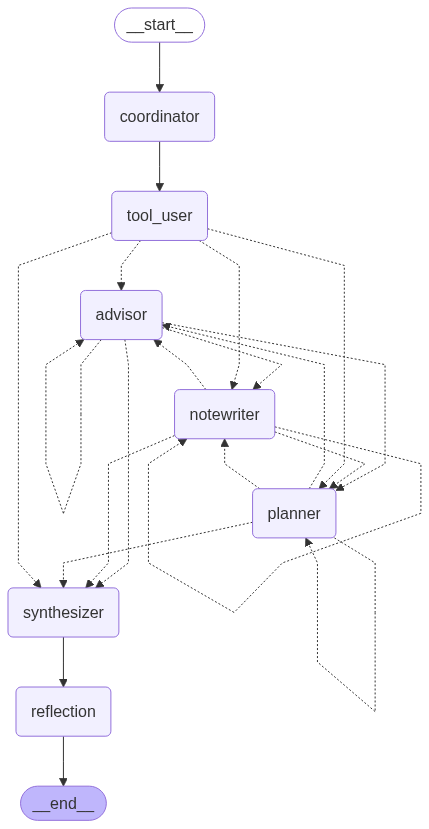

In [ ]:
from IPython.display import Image, display

try:

    graph = app.get_graph()


    png_data = graph.draw_mermaid_png()


    display(Image(png_data))

except Exception as e:
    print(f"Lỗi khi vẽ graph: {e}")